In [1]:
import pandas as pd
import numpy as np
import pycountry as pyc
import re
import pycountry_convert as pycon
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Add Granularity:

In [2]:
data = pd.read_csv('Michelin_Details_2019.csv', index_col = 0)
data.head(5)

,name,address,min_price,max_price,currency,cuisine,description,star,comfort,delightful,services,phone,website,hours,lat,lon,url
0,Shin Sushi,"16573 Ventura Blvd., Encino, 91436, United States",50.0,75.0,USD,Japanese,"Set in a nondescript shopping center, this hig...",1.0,2.0,0.0,"['New establishment in the guide', 'Establishm...",+1 818-616-4148,Not Available,Dinner Tue - Sat,34.157840,-118.494150,https://guide.michelin.com/en/california/encin...
1,Hayato,"1320 E. 7th St., Ste. 126, Los Angeles, 90001,...",75.0,150.0,USD,Japanese,The entrance can be a bit tricky to locate wit...,1.0,3.0,0.0,"['New establishment in the guide', 'Establishm...",+1 213-395-0607,www.hayatorestaurant.com,Dinner Tue - Sat,34.033110,-118.242650,https://guide.michelin.com/en/california/us-lo...
2,Angler,"132 The Embarcadero, San Francisco, 94101, Uni...",75.0,150.0,USD,Contemporary,Pitched as a more casual counterpart to the st...,1.0,3.0,0.0,"['Notable cocktail list', 'Wheelchair accessib...",+1 415-872-9442,www.anglerrestaurants.com,Lunch Thu - Sat Dinner nightly,37.793167,-122.392130,https://guide.michelin.com/en/california/san-f...
3,Harbor House,"5600 CA-1, Elk, United States",75.0,150.0,USD,Californian,You’ll drive along winding roads past sloping ...,1.0,3.0,1.0,"['Notable wine list', 'New establishment in th...",+1 800-720-7474,www.theharborhouseinn.com,Dinner Thu - Mon,39.135876,-123.719444,https://guide.michelin.com/en/california/elk/r...
4,Addison,"5200 Grand Del Mar Way, San Diego, 92130, Unit...",75.0,150.0,USD,Contemporary,"Among other luxuries, an evening at the Addiso...",1.0,5.0,0.0,"['Notable cocktail list', 'Wheelchair accessib...",+1 858-314-1900,www.addisondelmar.com,Dinner Tue - Sat,32.939903,-117.200130,https://guide.michelin.com/en/california/us-sa...


### Add Country & Continent:

In [3]:
addresses = [item.split(',') for item in data.address]
country = [item[-1].strip() for item in addresses]
data['country'] = country

In [4]:
def replace_country(text):
    text = re.sub('South Korea', 'Korea, Republic of', text)
    text = re.sub('Republic of Ireland', 'Ireland', text)
    
    return text

In [5]:
data['country'] = data['country'].apply(lambda x: replace_country(x))
data['country_alpha2'] = data['country'].apply(lambda x: pyc.countries.lookup(x).alpha_2)
data['continent_code'] = data['country_alpha2'].apply(lambda x: pycon.country_alpha2_to_continent_code(x))

# Convert Currencies:

In [6]:
currency_url = 'https://www.x-rates.com/table/?from=USD&amount=1'
currency_page = requests.get(currency_url)
currency_soup = BeautifulSoup(currency_page.content, 'html.parser')

In [7]:
currency_table = currency_soup.find_all(class_ = 'tablesorter ratesTable')

In [8]:
home = []
foreign = []
value = []
for item in currency_table[0].find_all('a'):
    link = item['href']
    home.append(re.findall(r'=(.*)&', link)[0])
    foreign.append(re.findall(r'to=(.*)', link)[0])
    value.append(item.contents[0])

In [9]:
converter = pd.DataFrame([home, foreign, value]).T
converter.columns = ['from', 'to', 'conversion_rate']
converter.head(5)

,from,to,conversion_rate
0,USD,ARS,63.961559
1,ARS,USD,0.015634
2,USD,AUD,1.695750
3,AUD,USD,0.589710
4,USD,BHD,0.376000


In [10]:
converted_price = []
for index, row in data.iterrows():
    conversion = row.currency
    if conversion == 'USD':
        converted_price.append((row.min_price, row.max_price))
    else:
        rate_table = converter[converter['from'] == conversion]
        rate = rate_table['conversion_rate']
        try:
            rate = float(rate.values[0])
            converted_price.append((round(row.min_price * rate, 2), round(row.max_price * rate, 2)))
        except:
            converted_price.append((0, 0))

In [11]:
data['USD_min_price'] = [item[0] for item in converted_price]
data['USD_max_price'] = [item[1] for item in converted_price]

In [12]:
data[['min_price', 'USD_min_price', 'currency']]

,min_price,USD_min_price,currency
0,50.0,50.00,USD
1,75.0,75.00,USD
2,75.0,75.00,USD
3,75.0,75.00,USD
4,75.0,75.00,USD
...,...,...,...
2614,20.0,13.80,SGD
2615,50.0,34.49,SGD
2616,48.0,33.11,SGD
2617,88.0,60.70,SGD


# Clean & Aggregate Cuisine:

In [13]:
data['cuisine'] = data['cuisine'].apply(lambda x: x.upper().strip())
data['aggregate_cuisine'] = data['cuisine'].copy()

In [14]:
def aggregating_cuisines(text):
    
    text = re.sub('ASIAN INFLUENCES', 'ASIAN', text)
    text = re.sub('CLASSIC CUISINE', 'CLASSIC', text)
    text = re.sub('MODERN CUISINE', 'MODERN', text)
    text = re.sub(r'INTERNATIONAL|WORLD CUISINE', 'FUSION', text)
    text = re.sub('TRADITIONAL BRITISH', 'BRITISH', text)
    
    text = re.sub('VEGAN','VEGETARIAN', text)    
    text = re.sub(r'SUSHI|TEPPANYAKI', 'JAPANESE', text)
    text = re.sub('GALICIAN', 'SPANISH', text)
    text = re.sub(r'HANG ZHOU|HUNANESE AND SICHUAN|SHANGHAINESE|SICHUAN-HUAI YANG|TAIWANESE|TAIZHOU|ZHEJIANG', 'CHINESE', text)
    text = re.sub(r'SICHUAN', 'CHINESE', text)
    text = re.sub(r'DIM SUM|BEIJING-CANTONESE|CANTONESE ROAST MEATS|NOODLES AND CONGEE',  'CANTONESE', text)
    text = re.sub(r'APULIAN|CAMPANIAN|CUISINE FROM ABRUZZO|EMILIAN|MANTUAN|PIEDMONTESE|TUSCAN', 'ITALIAN', text)
    text = re.sub(r'CORSICAN|LYONNAISE|CLASSIC FRENCH|PROVENÇAL', 'FRENCH', text)
    
    text = re.sub(r'CREATIVE ', '', text)
    text = re.sub(r' CUISINE', '', text)
    text = re.sub(r'MODERN ', '', text)
    text = re.sub(r' CONTEMPORARY', '', text)
    
    #The following are below threshold of 1% of total entries and will be combined:
    text = re.sub(r'AUSTRIAN|SCOTTISH|ISRAELI|HOME COOKING', 'EUROPEAN', text)
    text = re.sub('BARBECUE', 'JAPANESE', text) #this is Japanese BBQ in Taiwan
    text = re.sub(r'MOROCCAN|GREEK', 'MEDITERRANEAN', text)
    text = re.sub('MEATS AND GRILLS', 'FRENCH', text) #this restaurant serves French-style meats
    text = re.sub(r'DANISH', 'SCANDINAVIAN', text)
    
    
    return text


In [15]:
data[data['cuisine'] == 'ORGANIC']

,name,address,min_price,max_price,currency,cuisine,description,star,comfort,delightful,...,hours,lat,lon,url,country,country_alpha2,continent_code,USD_min_price,USD_max_price,aggregate_cuisine
184,Kaatje bij de Sluis,"Brouwerstraat 20, Blokzijl, 8356 DV, Netherlands",52.0,98.0,EUR,ORGANIC,Blokzijl is a picturesque part of the Netherla...,1.0,2.0,1.0,...,"Closed: 22 December-1 January, Sunday, Monday",52.726750,5.960619,https://guide.michelin.com/en/overijssel/blokz...,Netherlands,NL,EU,56.60,106.67,ORGANIC
258,Vermeer,"Prins Hendrikkade 59, Amsterdam, 1012 AD, Neth...",70.0,90.0,EUR,ORGANIC,Vermeer has become the culinary playground of ...,1.0,3.0,0.0,...,"Closed: 19 July-10 August, 25 December-10 Janu...",52.376486,4.900345,https://guide.michelin.com/en/noord-holland/am...,Netherlands,NL,EU,76.19,97.96,ORGANIC
372,Arabelle Meirlaen,"chemin de Bertrandfontaine 7, Marchin, 4570, B...",50.0,125.0,EUR,ORGANIC,Intuition is the name of the game at Arabelle’...,1.0,3.0,1.0,...,"Closed: Monday, Tuesday, Wednesday, Saturday l...",50.486631,5.221775,https://guide.michelin.com/en/liege/marchin/re...,Belgium,BE,EU,54.42,136.05,ORGANIC


In [16]:
data['aggregate_cuisine'] = data['cuisine'].apply(lambda x: aggregating_cuisines(x))

In [17]:
print(len(set(data['aggregate_cuisine'])))
set(data['aggregate_cuisine'])

40


{'AMERICAN',
 'ASIAN',
 'AUSTRALIAN',
 'BASQUE',
 'BRITISH',
 'CALIFORNIAN',
 'CANTONESE',
 'CANTONESE-CHINESE',
 'CHINESE',
 'CLASSIC',
 'CONTEMPORARY',
 'COUNTRY COOKING',
 'CREATIVE',
 'EUROPEAN',
 'FRENCH',
 'FUJIAN',
 'FUSION',
 'GASTROPUB',
 'INDIAN',
 'INNOVATIVE',
 'ITALIAN',
 'JAPANESE',
 'KOREAN',
 'MARKET',
 'MEDITERRANEAN',
 'MEXICAN',
 'MIDDLE EASTERN',
 'MODERN',
 'ORGANIC',
 'PERANAKAN',
 'REGIONAL',
 'SCANDINAVIAN',
 'SEAFOOD',
 'SPANISH',
 'STEAKHOUSE',
 'STREET FOOD',
 'TEOCHEW',
 'THAI',
 'TRADITIONAL',
 'VEGETARIAN'}

In [18]:
# Visualize distribution of cuisines:
pd.set_option('display.max_rows', 100)

groupby_cuisine = data.groupby('aggregate_cuisine').count()['name']
proportion = groupby_cuisine / data.shape[0]
proportion.sort_values()


aggregate_cuisine
TEOCHEW              0.000382
AUSTRALIAN           0.000382
BASQUE               0.000382
CANTONESE-CHINESE    0.000382
PERANAKAN            0.000382
MIDDLE EASTERN       0.000382
GASTROPUB            0.000382
FUJIAN               0.000382
STREET FOOD          0.000764
ORGANIC              0.001145
VEGETARIAN           0.002291
STEAKHOUSE           0.002291
SPANISH              0.002673
SCANDINAVIAN         0.002673
MEXICAN              0.003055
AMERICAN             0.003818
INDIAN               0.004200
FUSION               0.004582
COUNTRY COOKING      0.004582
CALIFORNIAN          0.004964
REGIONAL             0.004964
EUROPEAN             0.005727
ASIAN                0.006109
MARKET               0.006109
KOREAN               0.006491
THAI                 0.008400
CHINESE              0.008400
TRADITIONAL          0.009927
INNOVATIVE           0.011837
SEAFOOD              0.016800
MEDITERRANEAN        0.017182
CANTONESE            0.017946
BRITISH              0

In [19]:
regularized = proportion[proportion > .01]

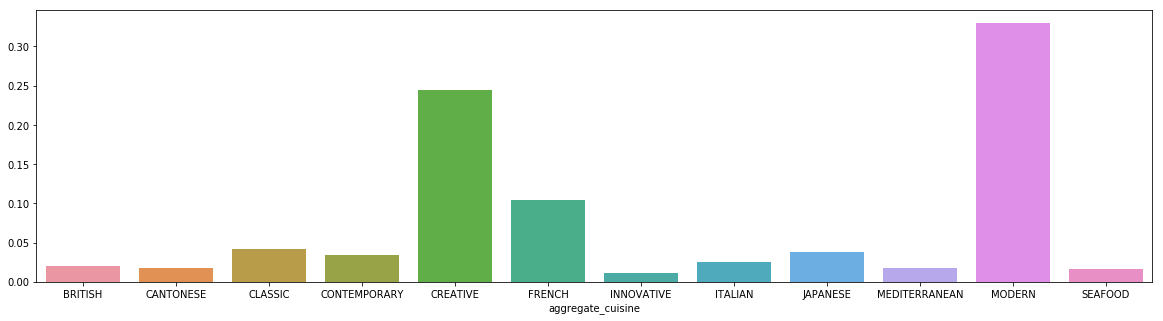

In [22]:
f, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=regularized.index, y= regularized.values, ax = ax)



In [23]:
data.shape

(2619, 23)

In [24]:
data.to_csv('Michelin_Details_2019_V2.csv')